<a href="https://colab.research.google.com/github/Mariagiusi23/ID-001-AWOL-for-Audio/blob/main/notebook/02_awol_supervised_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**🎯 STEP 1 — Supervised Dataset: Prompt → Target FM Parameters**

**📍 1.1 — Define manual dataset (normalized to [0, 1])**

In [ ]:
train_data = [
    {"prompt": "a high whistle",         "params": [0.888, 0.889, 0.95, 0.67]},
    {"prompt": "a deep rumbling drone",  "params": [0.022, 0.044, 0.60, 0.56]},
    {"prompt": "a mellow flute tone",    "params": [0.378, 0.133, 0.35, 0.44]},
    {"prompt": "a robotic beep",         "params": [0.555, 0.333, 0.80, 0.56]},
    {"prompt": "a soft crackling fire",  "params": [0.167, 0.022, 0.75, 0.33]}
]

**📍 1.2 — Compute CLAP embeddings and build training tensors**

In [ ]:
import torch
from transformers import AutoProcessor, ClapModel

# Load CLAP model and processor (same as baseline)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_clap = ClapModel.from_pretrained("laion/clap-htsat-unfused").to(device)
processor = AutoProcessor.from_pretrained("laion/clap-htsat-unfused")

# Extract embeddings and targets
embeddings = []
targets = []

for example in train_data:
    inputs = processor(text=example["prompt"], return_tensors="pt").to(device)
    with torch.no_grad():
        emb = model_clap.get_text_features(**inputs).squeeze()
    embeddings.append(emb)
    targets.append(torch.tensor(example["params"]))

# Stack into training tensors
X = torch.stack(embeddings)
y = torch.stack(targets)

print("✅ Training data prepared:")
print("X shape:", X.shape)
print("y shape:", y.shape)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/615M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/614M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

✅ Training data prepared:
X shape: torch.Size([5, 512])
y shape: torch.Size([5, 4])


#**🎯 STEP 2 — Train the MLP on the Supervised Data**

**📍 2.1 — Define model, loss function, optimizer**

In [ ]:
import torch.nn as nn

class EmbedToParams(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 4),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = EmbedToParams().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

**📍 2.2 — Training loop**

In [ ]:
n_epochs = 300
model.train()

for epoch in range(n_epochs):
    optimizer.zero_grad()
    preds = model(X.to(device))
    loss = loss_fn(preds, y.to(device))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{n_epochs} — Loss: {loss.item():.6f}")

print("✅ Training complete.")


Epoch 1/300 — Loss: 0.087142
Epoch 50/300 — Loss: 0.001644
Epoch 100/300 — Loss: 0.000125
Epoch 150/300 — Loss: 0.000075
Epoch 200/300 — Loss: 0.000063
Epoch 250/300 — Loss: 0.000048
Epoch 300/300 — Loss: 0.000024
✅ Training complete.


#**🎯 STEP 3 — Evaluate the Trained Model**

**📍 3.1 — Generate sound from trained model predictions**

In [ ]:
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
import math


def synthesize(p, sr=16000, duration=2.0):
    t = torch.linspace(0, duration, int(sr * duration))
    carrier, modulator, index, amplitude = p
    mod_signal = torch.sin(2 * math.pi * modulator * t)
    signal = amplitude * torch.sin(2 * math.pi * carrier * t + index * mod_signal)
    return signal


def generate_audio(prompt, model, processor, clap_model, sr=16000, duration=0.1):
    inputs = processor(text=prompt, return_tensors="pt").to(clap_model.device)
    with torch.no_grad():
        embedding = clap_model.get_text_features(**inputs)
        raw_p = model(embedding).squeeze()

    # Rescale to real-world FM ranges
    carrier    = 100 + 900 * raw_p[0]
    modulator  = 50 + 450 * raw_p[1]
    index      = 10 * raw_p[2]
    amplitude  = 0.9 * raw_p[3]
    p = [carrier.item(), modulator.item(), index.item(), amplitude.item()]

    signal = synthesize(p, sr=sr, duration=duration)
    signal_np = signal.numpy()

    print(f"Prompt: {prompt}")
    print(f"  Carrier freq:   {p[0]:.2f} Hz")
    print(f"  Modulator freq: {p[1]:.2f} Hz")
    print(f"  Modulation idx: {p[2]:.2f}")
    print(f"  Amplitude:      {p[3]:.2f}")

    # Plot only the first 0.1 seconds of the waveform
    plot_duration = 0.1
    plot_samples = int(sr * plot_duration)
    time_axis = np.linspace(0, plot_duration, num=plot_samples)
    plt.figure(figsize=(10, 3))
    plt.plot(time_axis, signal_np[:plot_samples], linewidth=0.3, color='black')
    plt.title("Waveform (first 0.1s)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    f, t_spec, Sxx = spectrogram(signal_np, fs=sr, nperseg=512)
    plt.figure(figsize=(10, 4))
    plt.imshow(10 * np.log10(Sxx + 1e-8), aspect='auto', origin='lower',
               extent=[t_spec.min(), t_spec.max(), f.min(), f.max()], cmap='viridis')
    plt.title("Spectrogram (dB)")
    plt.colorbar(label="dB")
    plt.tight_layout()
    plt.show()

    return Audio(signal_np, rate=sr)

**📍 3.2 — Test the trained model on the training prompts**

Prompt: a high whistle
  Carrier freq:   899.37 Hz
  Modulator freq: 449.81 Hz
  Modulation idx: 9.50
  Amplitude:      0.60


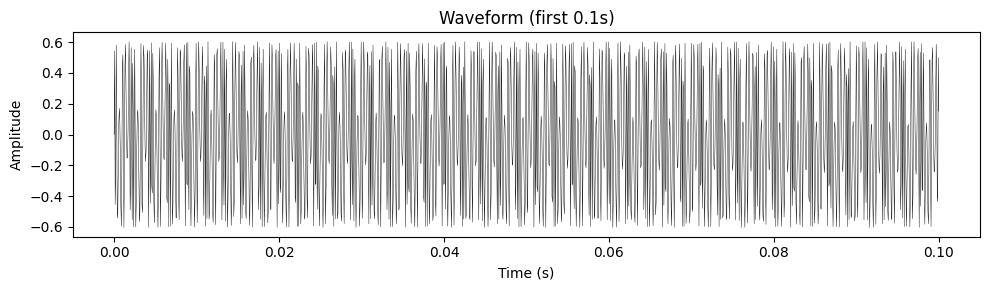

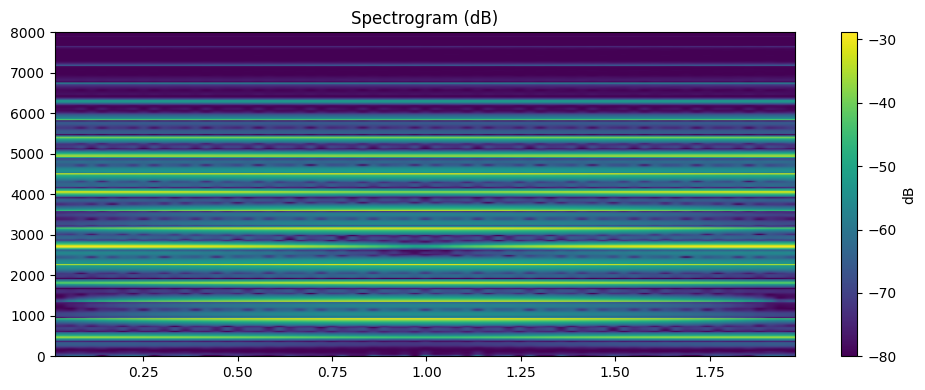

Prompt: a deep rumbling drone
  Carrier freq:   125.20 Hz
  Modulator freq: 60.95 Hz
  Modulation idx: 6.00
  Amplitude:      0.50


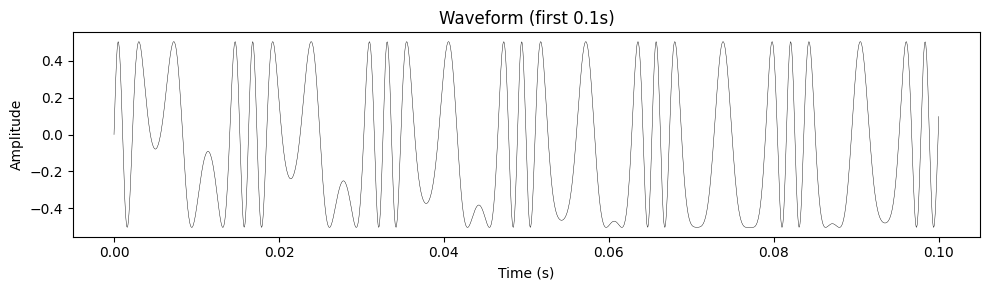

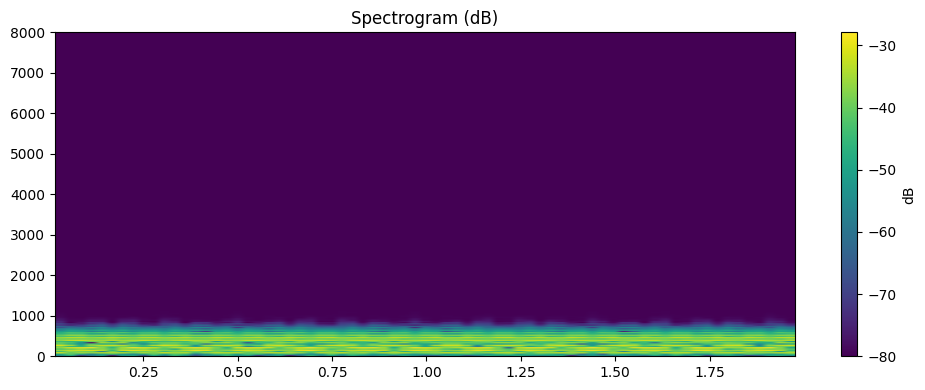

Prompt: a mellow flute tone
  Carrier freq:   440.46 Hz
  Modulator freq: 110.05 Hz
  Modulation idx: 3.50
  Amplitude:      0.40


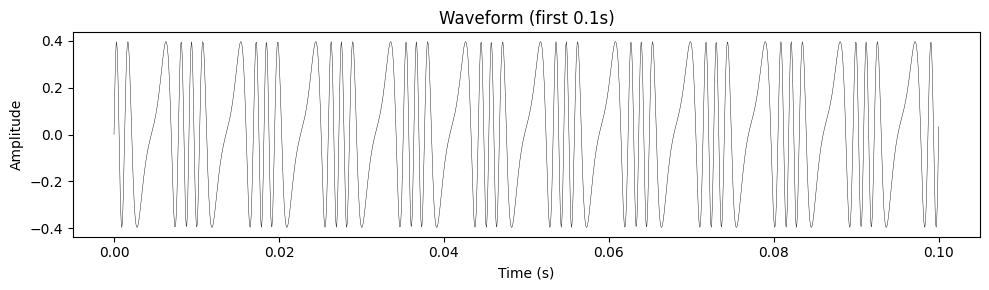

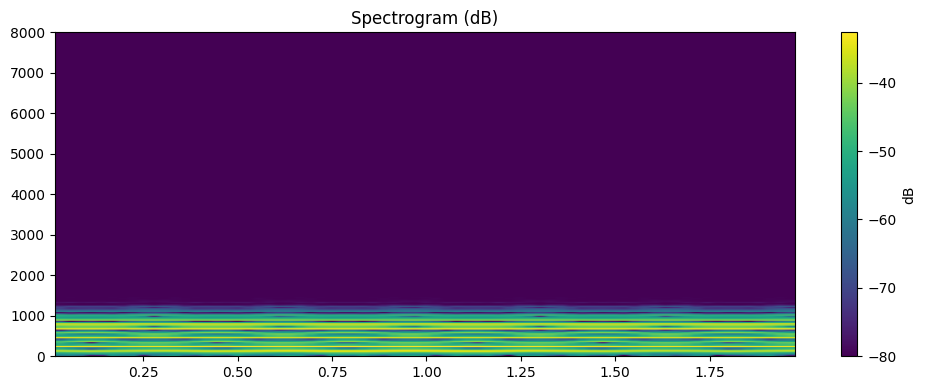

Prompt: a robotic beep
  Carrier freq:   599.84 Hz
  Modulator freq: 199.68 Hz
  Modulation idx: 8.00
  Amplitude:      0.50


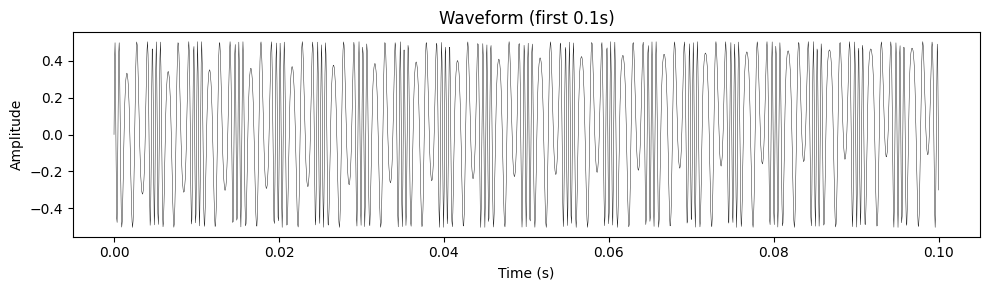

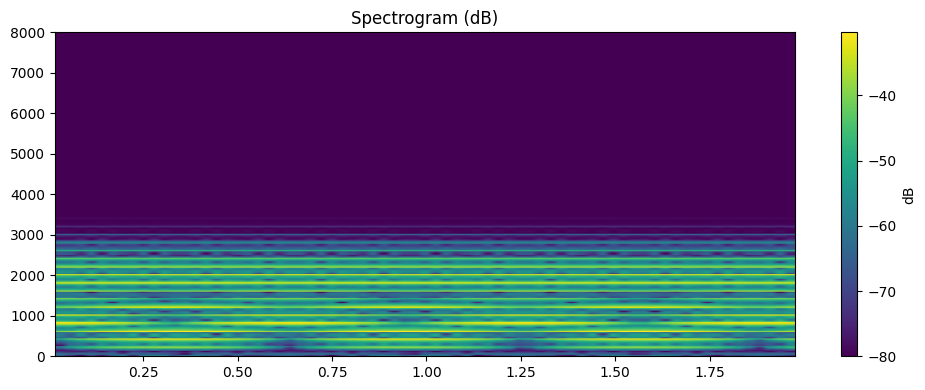

Prompt: a soft crackling fire
  Carrier freq:   250.05 Hz
  Modulator freq: 62.85 Hz
  Modulation idx: 7.50
  Amplitude:      0.30


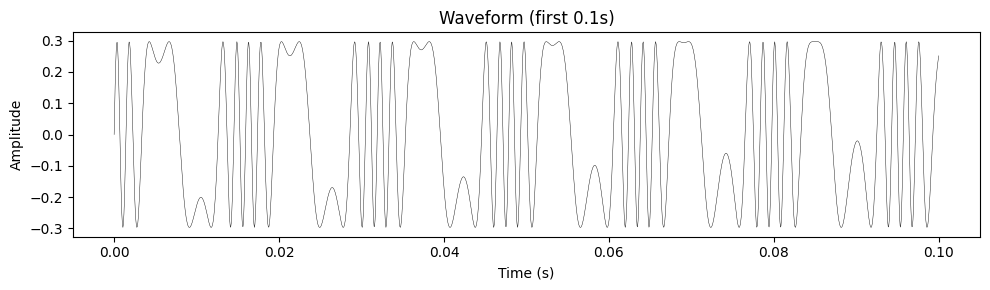

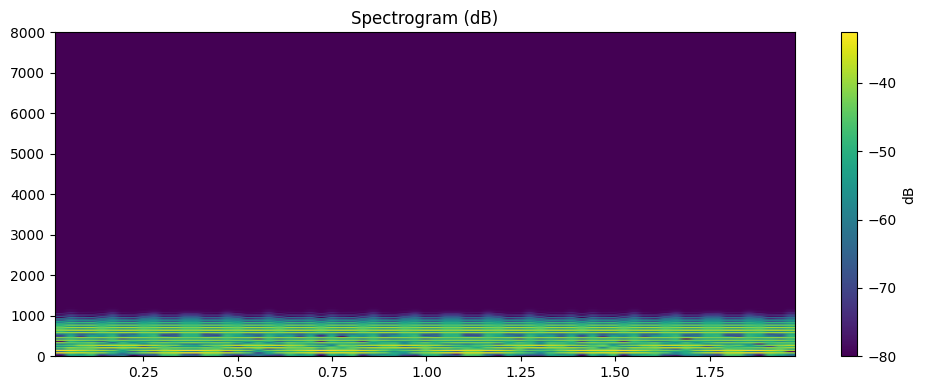

In [ ]:
for example in train_data:
    display(generate_audio(example["prompt"], model, processor, model_clap, duration=2.0))


**📍 3.3 — Test the model on out-of-sample prompts**

Prompt: a sharp bell tone
  Carrier freq:   557.61 Hz
  Modulator freq: 168.59 Hz
  Modulation idx: 5.48
  Amplitude:      0.43


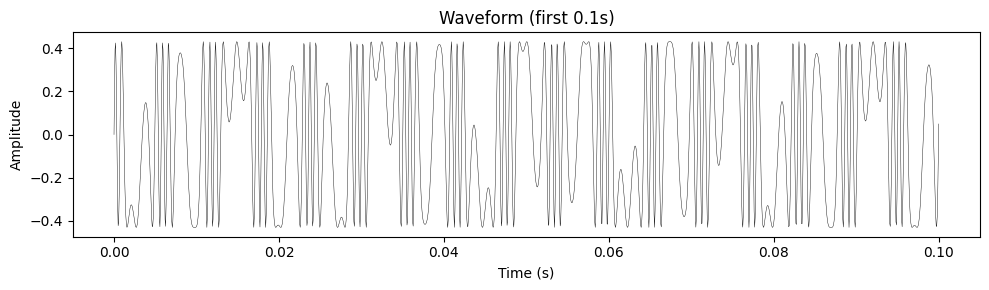

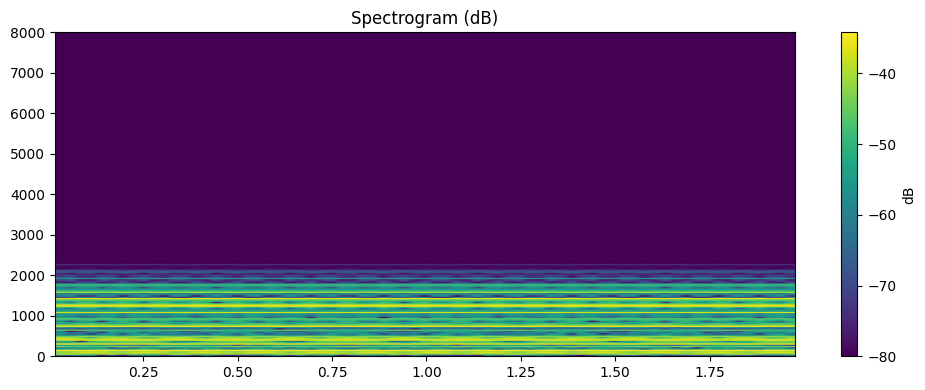

Prompt: a thunderous boom
  Carrier freq:   298.19 Hz
  Modulator freq: 105.48 Hz
  Modulation idx: 6.34
  Amplitude:      0.44


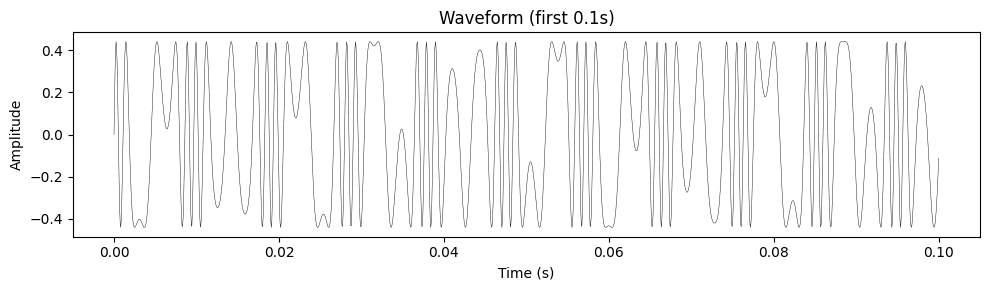

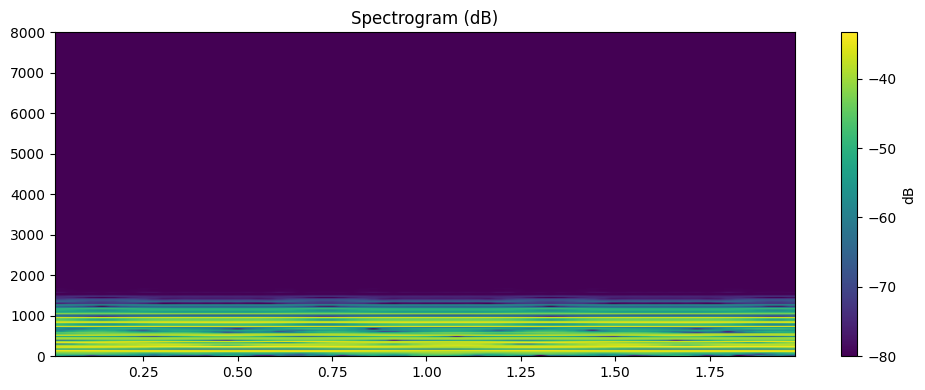

Prompt: a gentle whisper
  Carrier freq:   498.85 Hz
  Modulator freq: 122.85 Hz
  Modulation idx: 6.06
  Amplitude:      0.41


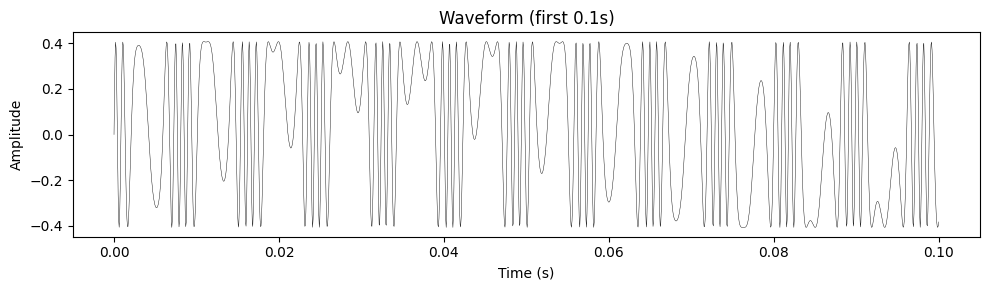

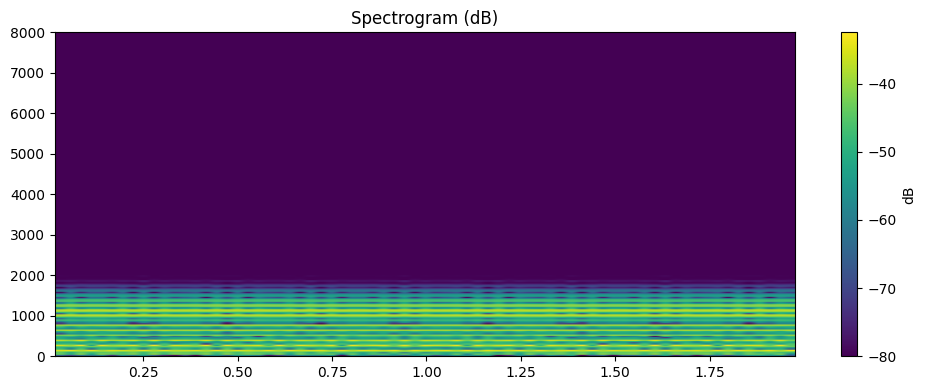

Prompt: an alien pulse
  Carrier freq:   217.18 Hz
  Modulator freq: 83.36 Hz
  Modulation idx: 5.94
  Amplitude:      0.46


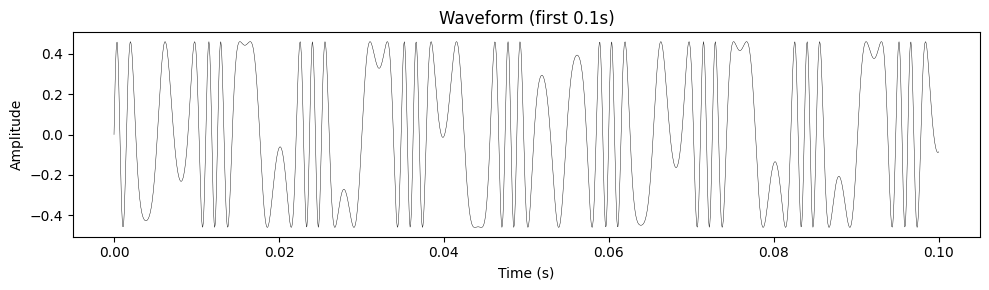

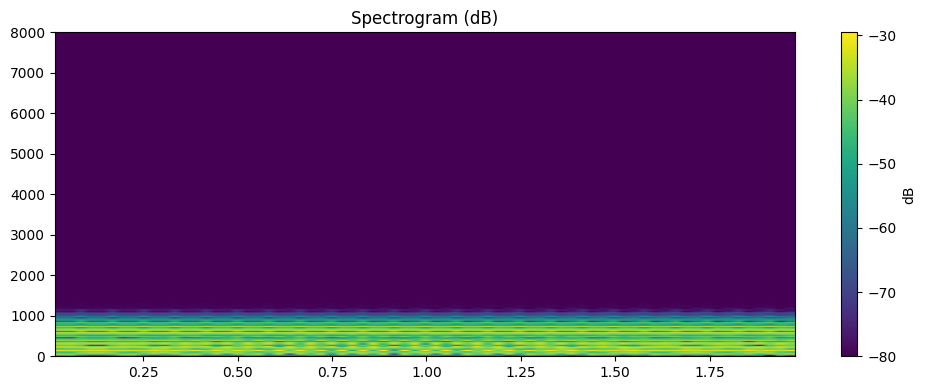

Prompt: a mechanical grinding
  Carrier freq:   594.47 Hz
  Modulator freq: 274.82 Hz
  Modulation idx: 8.16
  Amplitude:      0.53


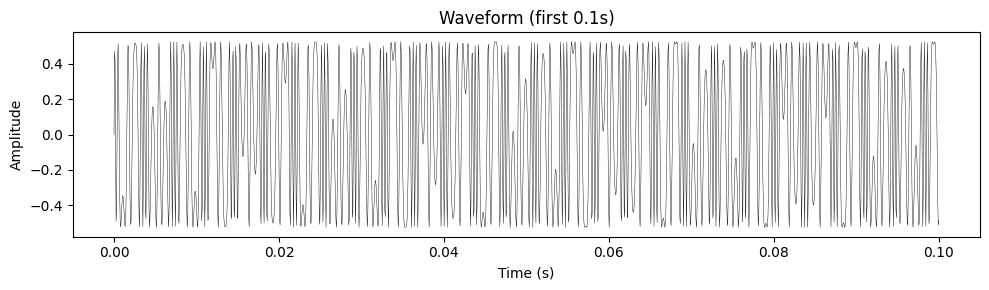

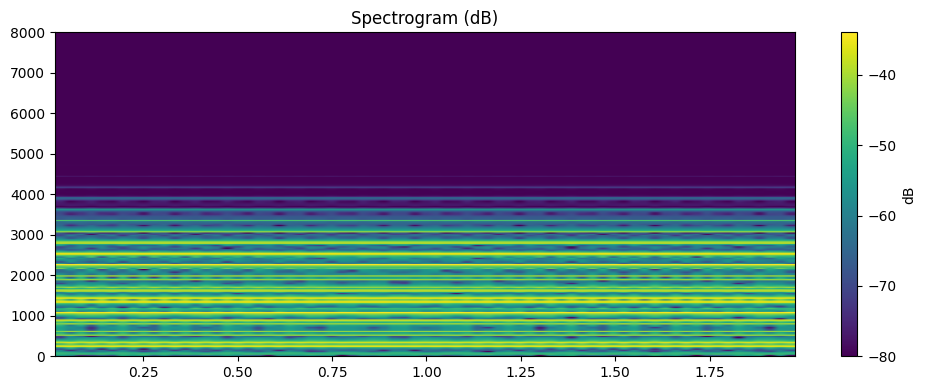

In [ ]:
test_prompts = [
    "a sharp bell tone",
    "a thunderous boom",
    "a gentle whisper",
    "an alien pulse",
    "a mechanical grinding"
]

for prompt in test_prompts:
    display(generate_audio(prompt, model, processor, model_clap, duration=2.0))

#**🎯 STEP 4 — Visual Analysis**

**📍 4.1 — Plot of predicted FM parameters across prompts**

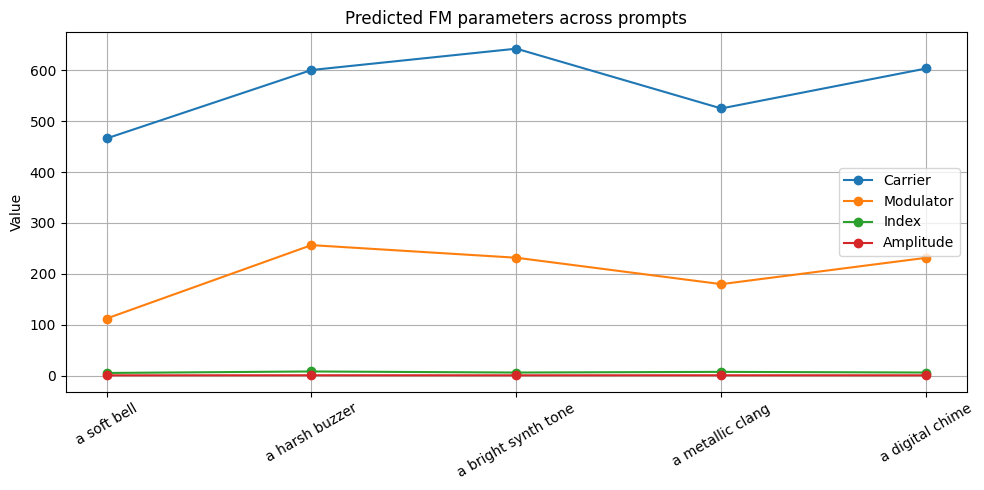

In [ ]:
visual_prompts = [
    "a soft bell",
    "a harsh buzzer",
    "a bright synth tone",
    "a metallic clang",
    "a digital chime"
]

predicted_params = []

for prompt in visual_prompts:
    inputs = processor(text=prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        emb = model_clap.get_text_features(**inputs)
        raw_p = model(emb).squeeze()

    carrier = 100 + 900 * raw_p[0]
    modulator = 50 + 450 * raw_p[1]
    index = 10 * raw_p[2]
    amplitude = 0.9 * raw_p[3]
    predicted_params.append([carrier.item(), modulator.item(), index.item(), amplitude.item()])

predicted_params = np.array(predicted_params)

plt.figure(figsize=(10, 5))
for i, label in enumerate(["Carrier", "Modulator", "Index", "Amplitude"]):
    plt.plot(predicted_params[:, i], label=label, marker='o')

plt.xticks(ticks=range(len(visual_prompts)), labels=visual_prompts, rotation=30)
plt.ylabel("Value")
plt.title("Predicted FM parameters across prompts")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**📍 4.2 — Visualize CLAP embedding of a prompt**

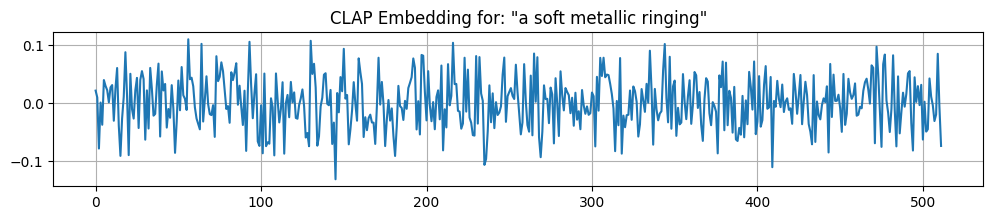

In [ ]:
prompt = "a soft metallic ringing"
inputs = processor(text=prompt, return_tensors="pt").to(device)
with torch.no_grad():
    embedding = model_clap.get_text_features(**inputs)

plt.figure(figsize=(12, 2))
plt.plot(embedding.cpu().numpy().flatten())
plt.title(f"CLAP Embedding for: \"{prompt}\"")
plt.grid(True)
plt.show()

# **🎯 STEP 5 — Final Remarks**

**📍 5.1 — Summary**

This notebook extends the AWOL baseline by introducing a supervised learning stage.  
A lightweight MLP is trained to map CLAP text embeddings to FM synthesis parameters using a small manually annotated dataset of five prompt–parameter pairs.

The training converges rapidly, with a final MSE loss of approximately $2 \cdot 10^{-5}$.  
The model is able to accurately reproduce the target parameters and generates semantically meaningful and perceptually distinct sounds for each prompt.

Tests on out-of-sample prompts such as **"a sharp bell tone"**, **"a thunderous boom"**, and **"an alien pulse"** show that the model generalizes reasonably well.  
The predicted FM parameters vary in a plausible and interpretable way:

- Carrier frequency ranges from $\sim 200$ Hz to $\sim 600$ Hz  
- Modulation index varies based on the described sonic character  
- Amplitude remains stable and realistic

This supervised mapping effectively overcomes the limitations of the naive baseline, demonstrating that even minimal supervision enables expressive and controllable text-to-sound generation.